Populating the interactive namespace from numpy and matplotlib
[[0.860877   0.00751321 0.29974568]
 [0.16217178 0.04754673 0.43672962]
 [0.80043584 0.65721951 0.36693407]]


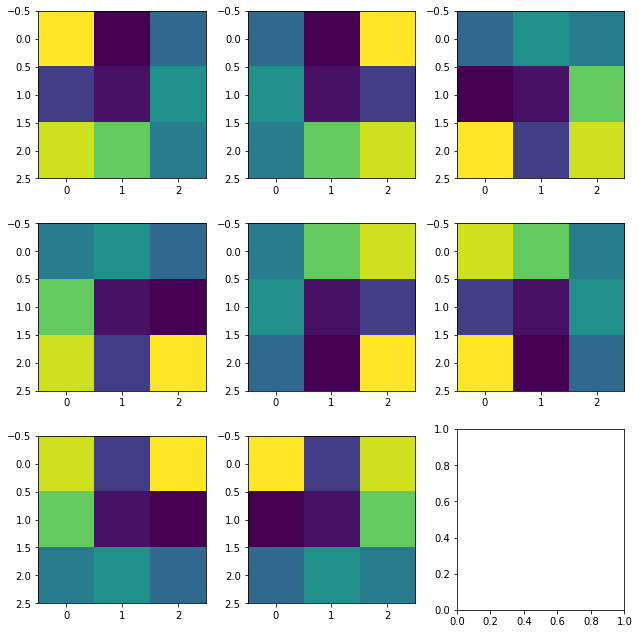

In [1]:
%pylab inline

A = np.random.rand(3,3, )
print (A)

def data_aug2d(A):
    return [A, np.fliplr(A), np.rot90(A), np.fliplr(np.rot90(A)), rot90(rot90(A)), np.fliplr(rot90(rot90(A))), 
     rot90(rot90(rot90(A))), np.fliplr(rot90(rot90(rot90(A))))]

fig, axs = subplots(3,3, figsize=(9,9)); row = 0
As = data_aug2d(A)
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(As[row]); row+=1
        if row == 8: break
fig.tight_layout()

### 以上是数据增强的测试代码，还没成功，忽略。。。从这里开始

##### for some cosmologies data are missing...!!!??? we have to skip them

In [35]:
%pylab inline
import numpy as np
import keras, os, pynbody, struct

lsstr = "ls /media/xiaodongli/0B9ADFB4341AD2BD/om_As/"

def cosmostr(om, As):
    return 'om%.3f' % om + '_As%.3f' % As

def snpfiles(cosmology, snpstr='c'):  #
    return os.popen(lsstr + cosmology + "*snap*" + snpstr + ".*").read().split()

def gridfiles(cosmology, snpstr='c'):
    return os.popen(lsstr + cosmology + "*grid*" + snpstr + ".*").read().split()

def mocklist():
    files = os.popen(lsstr + "om*.lua").read().split('\n')
    # *代替多个字母,即列出所有符合条件的.lua文件:om...
    cosmologies = []  # 宇宙学参数
    mocks = {}  # 模拟测试
    ifile = 0  # 有效文件
    for nowfile in files:
        # str[a:b]不存在时,返回'',不存在则忽略
        nowstr = nowfile[-39:-10]
        if nowstr == '':
            continue
        cosmologies.append(nowstr[0:15])
        ifile += 1
        try:
            mocks[nowstr[0:15]] = {'om': float(nowstr[2:7]), 'As': float(nowstr[10:15]),
                                   'sigma8': float(nowstr[23:29])}
            # 添加随机数种子
            ranseed = float(open(nowfile, 'r').readline().split()[2])  # 默认以所有空字符为分隔符,包括空格,\n,\t
            mocks[nowstr[0:15]]['ranseed'] = int(ranseed)
            # print(ranseed)
        except:
            pass
    return cosmologies, files, mocks

gridfile_dict = {}

cosmologies, filenames, infos = mocklist()
print('In total ', len(cosmologies), 'cosmologies')

print('Build up gridfile_dict... (for speed-up of load_grid()) ')
for cosmology in cosmologies:
    rlt = gridfiles(cosmology)
    if rlt == []:
        print ('\tmissing cosmology!', cosmology)
    else:
        gridfile_dict[cosmology] = rlt[0]
np.random.shuffle(cosmologies)

Populating the interactive namespace from numpy and matplotlib
In total  465 cosmologies
Build up gridfile_dict... (for speed-up of load_grid()) 
	missing cosmology! om0.180_As2.040
	missing cosmology! om0.180_As2.100
	missing cosmology! om0.180_As2.120
	missing cosmology! om0.180_As2.140
	missing cosmology! om0.180_As2.200
	missing cosmology! om0.180_As2.220
	missing cosmology! om0.180_As2.260


In [36]:
def load_grid(gridfile, snpstr='c', printinfo=False):  # 网格加载
    #gridfile = os.popen(lsstr + cosmology+"_sigma8_*grid*" + snpstr + ".*").read().split()[0]
    #print('load in gridfile : ', gridfile, '...')
    nowf = open(gridfile, 'rb')  # 以二进制形式读取文件
    # struct:对python基本类型值与用python字符串格式表示的C struct类型间转化
    size = struct.unpack('f' * 1, nowf.read(4 * 1))[0]
    grid_nc = struct.unpack('i' * 1, nowf.read(4 * 1))[0]
    data = struct.unpack('f' * grid_nc ** 3, nowf.read(4 * grid_nc ** 3))
    if printinfo:
        print('read in box size     \n\t', size)
        print('read in num_grid      \n\t', grid_nc)
        print('read in coarse grid \n\tsize    : ', len(data), '\n\texpect  : ', grid_nc ** 3)

    nowf.close()
    return np.array(data).reshape((grid_nc, grid_nc, grid_nc))

def subcubes(A):
    rlt = []
    for row1 in [0, 32, 64]:
        for row2 in [0, 32, 64]:
            for row3 in [0, 32, 64]:
                rlt.append(A[row1:row1+32,row2:row2+32,row3:row3+32])
    return rlt

def data_augument(A):
    rlt = []


In [39]:
n_train = int(len(cosmologies)*4/5)
print(n_train)
cosmologies_train, cosmologies_test = cosmologies[0:n_train], cosmologies[n_train:]

372


In [45]:
# lsstr = "ls /media/minstrel/Seagate/cola_multiverse/om_As/"
# 初始化数据集,因函数定义中参数不可转为全局变量
# 此过程受train_test_split的test_size参数的影响,则今后更改或维护程序应注意
test_size = 0.3
batch_size = int(n_train / 15)
num_subcube = 64
num_data_augument = 48

x_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))  # 因test_size=0.3,保证初始化矩阵的形状与后面的相同
x_test = np.zeros((int(test_size*batch_size)+1,32,32,32, 1))
y_test = np.zeros((int(test_size*batch_size)+1, 2))
y_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))


###  xiaodong: 重新写了 load_grid 程序。。。之前有错误！！！！（好像只会 load 进来一个 om...)
def train_generator():  # 必须无限循环yield数据,全部数据遍历后再重新遍历数据,为下一个epoch yield 数据
    i = 0
    while 1:
        X = []
        y = []
        global x_train, x_test, y_test, y_train, test_size, batch_size
        #print(' load in ', batch_size * i, 'to', batch_size * (i + 1), '... len(cosmologies)=',
        #      len(cosmologies))
        for cosmology in cosmologies[batch_size * i: batch_size * (i + 1)]:
            try:
                gridfile = gridfile_dict[cosmology]
                gridfile_exist = True
            except:
                #print('skip cosmology ', cosmology, '!!!')
                gridfile_exist = False
            if gridfile_exist:
                griddata = load_grid(gridfile, 'c')
                for subcube in subcubes(griddata):
                    X.append(subcube)
                    y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
        X = np.array(X)
        y = np.array(y)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
        x_train = x_train.reshape(-1, 32, 32, 32, 1)
        x_test = x_test.reshape(-1, 32, 32, 32, 1)
        i += 1
        yield x_train, y_train  # tuple 类型
        # 15个批次后重新遍历数据,此循环即死循环
        if i == 465//batch_size:
            i = 0


In [46]:
from keras import Sequential, layers
from sklearn import model_selection, metrics

model1 = keras.Sequential([
    layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
    layers.Conv3D(32, (3, 3, 3), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    layers.BatchNormalization(),
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    layers.BatchNormalization(),
    layers.Conv3D(128, (3, 3, 3), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, ),
])
model1.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])



# *************************************************************************************************
model1.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test,y_test))


Epoch 1/100
19/19 [==============================] - 214s 11s/step - loss: 1.8656 - mean_squared_error: 1.8656 - val_loss: 0.2085 - val_mean_squared_error: 0.2085
Epoch 2/100
19/19 [==============================] - 207s 11s/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.2478 - val_mean_squared_error: 0.2478
Epoch 3/100
19/19 [==============================] - 207s 11s/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.2509 - val_mean_squared_error: 0.2509
Epoch 4/100
19/19 [==============================] - 209s 11s/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.1859 - val_mean_squared_error: 0.1859
Epoch 5/100
19/19 [==============================] - 207s 11s/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.1433 - val_mean_squared_error: 0.1433
Epoch 6/100
19/19 [==============================] - 208s 11s/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 7/100
19/19 [===

19/19 [==============================] - 210s 11s/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 52/100
19/19 [==============================] - 210s 11s/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 53/100
19/19 [==============================] - 209s 11s/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 54/100
19/19 [==============================] - 208s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 55/100
19/19 [==============================] - 208s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 56/100
19/19 [==============================] - 207s 11s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 57/100
19/19 [=========

In [ ]:
from keras import Sequential, layers
from sklearn import model_selection, metrics

model2 = keras.Sequential([
    layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
    layers.Conv3D(2, (3, 3, 3), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(12, (3, 3, 3), activation='relu', ),
    layers.AveragePooling3D(pool_size=(2, 2, 2),),
    layers.BatchNormalization(),
    layers.Conv3D(64, (9, 9, 9), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(64, (3, 3, 3), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(128, (2, 2, 2), activation='relu', ),
    layers.BatchNormalization(),
    layers.Conv3D(128, (2, 2, 2), activation='relu', ),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, ),
])
model2.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])



# *************************************************************************************************
model2.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=300,
                    verbose=1,
                    validation_data=(x_test,y_test))


### Test section

In [55]:
def create_validate_sample(nsample, use_random=True, startid=None ):
    cosmologies = list(gridfile_dict); ncosmo = len(cosmologies)
    if use_random:
        rows = [np.random.randint(0,ncosmo) for row in range(nsample)];
        rows = list(set(rows))
        while len(rows) < nsample:
            rows = rows + [np.random.randint(0,ncosmo) for row in range(nsample - len(rows))];
            rows = list(set(rows))
    else:
        rows = range(startid, startid+nsample)
    x, y =[], []
    for row in rows:
        cosmology = cosmologies[row]
        gridfile = gridfile_dict[cosmology]
        griddata = load_grid(gridfile)
        for subcube in subcubes(griddata):
            x.append(subcube)
            y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
    x = np.array(x); x = x.reshape(-1, 32, 32, 32, 1); y = np.array(y)
    return x, y

def plot_test(model, x, y, plot_avg_predict = True, fig=None, ax = None, plot_subpoints=False):
    y_predict = model.predict(x); 
    
    if fig == None or ax ==None:
        fig, ax = subplots(figsize=(14,6))
    cs = range(len(y)); cs = cs / mean(cs)
    ax.scatter(y[:,0], y[:,1], c='b', marker='*', label='input', s=200)
    if plot_subpoints:
        ax.scatter(y_predict[:,0], y_predict[:,1], c='g',  marker='p', s=50, label='outputs')
    
        
    om_test, w_test = y[:,0], y[:,1]
    om_predict, w_predict = y_predict[:,0], y_predict[:,1]
    
    if plot_avg_predict:
        ax.scatter(mean(y_predict[:,0]), mean(y_predict[:,1]), marker='*', c='r', label='output_avg', s=200)
        ax.plot([om_test[0], mean(y_predict[:,0])], [w_test[0], mean(y_predict[:,1])], lw=2, c='k', ls='--' )

    
    #for row in range(len(om_predict)):
    #    ax.plot( [om_predict[row], om_test[row]], [w_predict[row], w_test[row]], lw=0.5, c='gray' )
    ax.set_xlabel(r'$\Omega_m$',fontsize=16); ax.set_ylabel(r'$\sigma_8$',fontsize=16)
    ax.legend()   
    return fig, ax

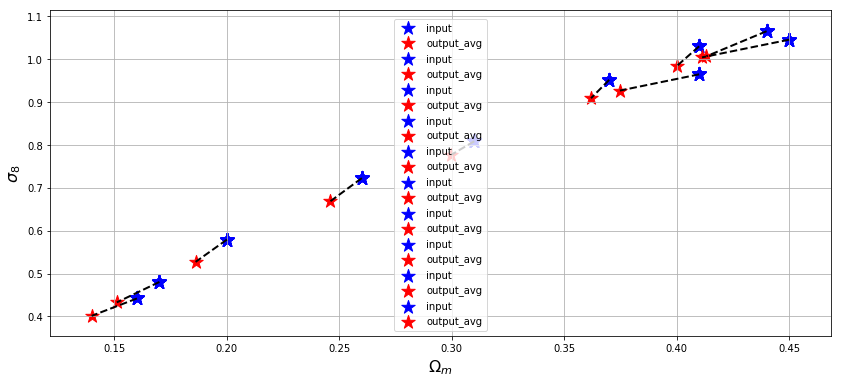

In [56]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model1, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()

##### model1, 10 epochs: Don't run it! (参数已改不可恢复）

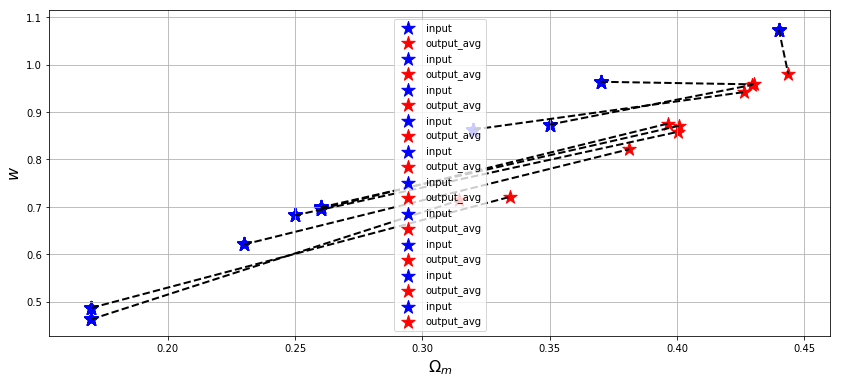

In [176]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model1, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()

##### 50 epochs`5

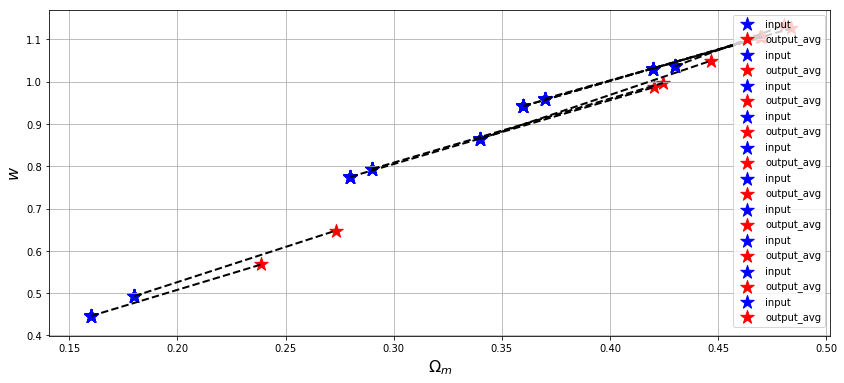

In [181]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model1, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()

##### 100 epochs

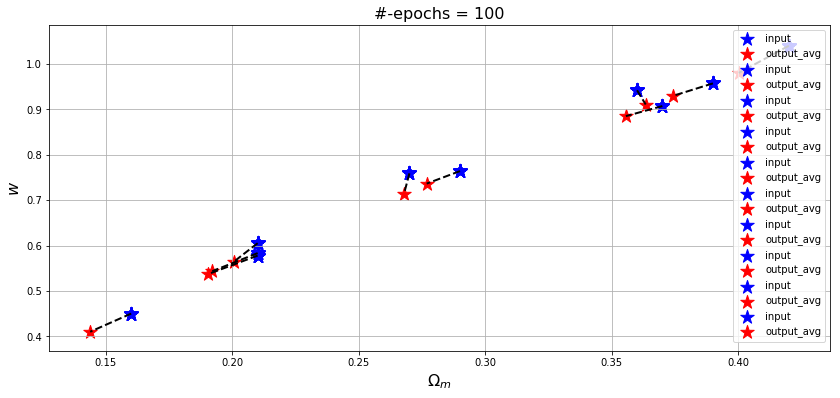

In [52]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model1, x_test, y_test, fig=fig, ax=ax)
ax.set_title('#-epochs = '+str(100), fontsize=16)
ax.grid(); plt.show()

##### 207 epochs

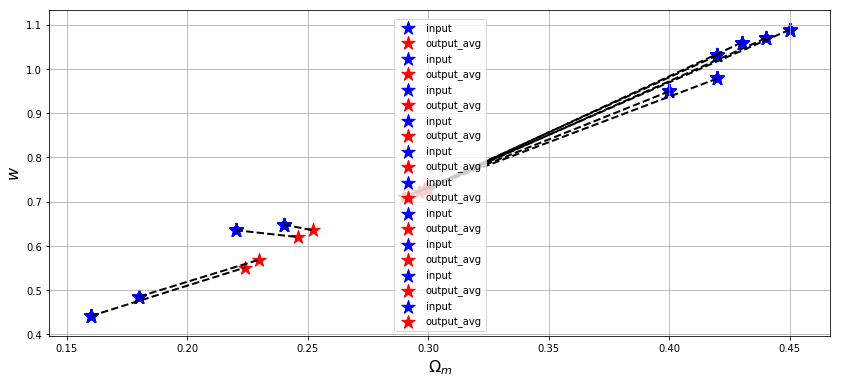

In [8]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model1, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()

#### This shows how to save and load a model

In [68]:

model1.save('model1.h5')

!ls model1.h5 -alh

model1_load = keras.models.load_model('model1.h5')

print(model1.predict(x_test[0:1]))
print(model1_load.predict(x_test[0:1]))

-rw-rw-r-- 1 xiaodongli xiaodongli 19M 5月  13 10:41 model1.h5
[[0.19713476 0.53735685]]
[[0.19713476 0.53735685]]


#########################################
Do a fit for  5 epochs:
#########################################
Epoch 1/5
19/19 [==============================] - 222s 12s/step - loss: 2.3238 - mean_squared_error: 2.3238 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/5
19/19 [==============================] - 218s 11s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/5
19/19 [==============================] - 215s 11s/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 4/5
19/19 [==============================] - 219s 12s/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 5/5
19/19 [==============================] - 215s 11s/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0082 - val_mean_squared_error: 0.0082


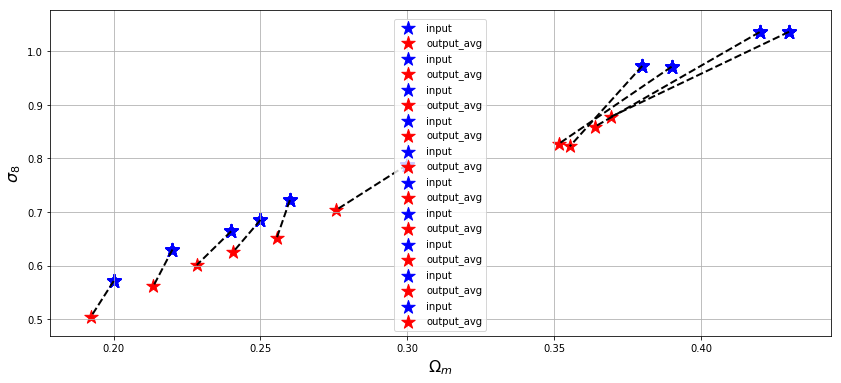

#########################################
Do a fit for  10 epochs:
#########################################
Epoch 1/10
19/19 [==============================] - 223s 12s/step - loss: 1.8676 - mean_squared_error: 1.8676 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 2/10
19/19 [==============================] - 215s 11s/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/10
19/19 [==============================] - 216s 11s/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 4/10
19/19 [==============================] - 215s 11s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/10
19/19 [==============================] - 215s 11s/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 6/10
19/19 [==============================] - 217s 11s/step - loss: 0.0107 

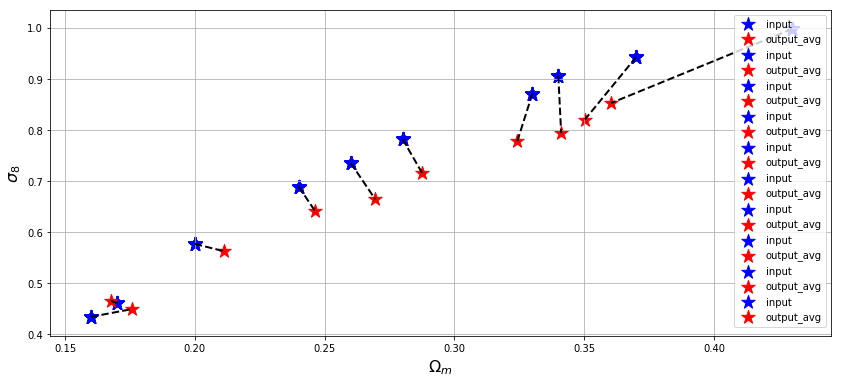

#########################################
Do a fit for  15 epochs:
#########################################
Epoch 1/15
19/19 [==============================] - 226s 12s/step - loss: 2.0394 - mean_squared_error: 2.0394 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2/15
19/19 [==============================] - 215s 11s/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/15
19/19 [==============================] - 216s 11s/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 4/15
19/19 [==============================] - 217s 11s/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/15
19/19 [==============================] - 216s 11s/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/15
19/19 [==============================] - 217s 11s/step - loss: 0.0116 

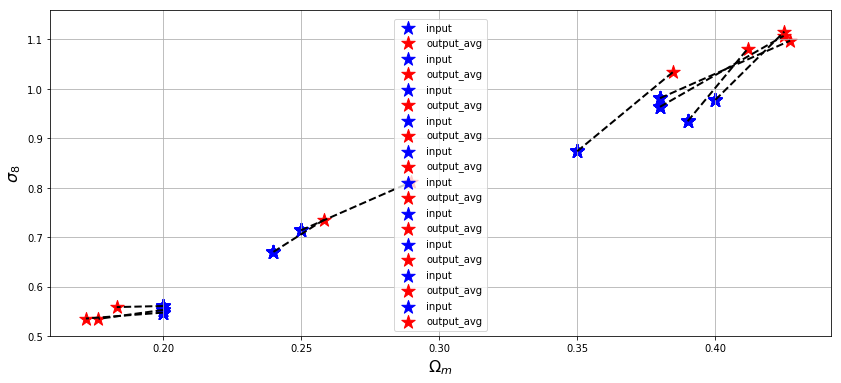

#########################################
Do a fit for  20 epochs:
#########################################
Epoch 1/20
19/19 [==============================] - 223s 12s/step - loss: 1.4189 - mean_squared_error: 1.4189 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 2/20
19/19 [==============================] - 213s 11s/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 3/20
19/19 [==============================] - 210s 11s/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 4/20
19/19 [==============================] - 211s 11s/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 5/20
19/19 [==============================] - 210s 11s/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 6/20
19/19 [==============================] - 212s 11s/step - loss: 0.0137 

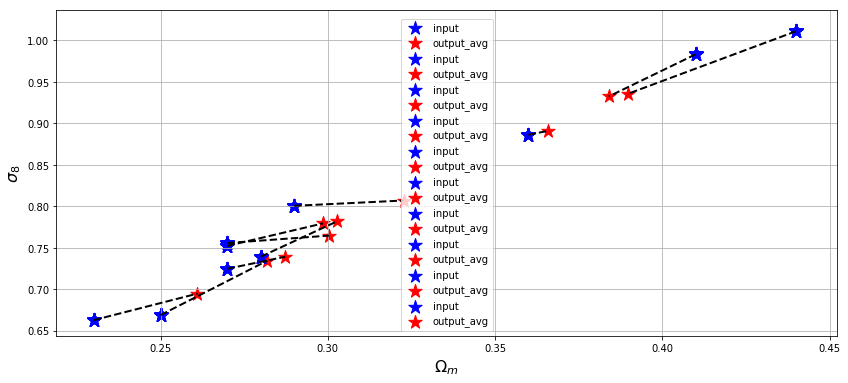

#########################################
Do a fit for  30 epochs:
#########################################
Epoch 1/30
19/19 [==============================] - 219s 12s/step - loss: 2.0888 - mean_squared_error: 2.0888 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 2/30
19/19 [==============================] - 210s 11s/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 3/30
19/19 [==============================] - 209s 11s/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 4/30
19/19 [==============================] - 210s 11s/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 5/30
19/19 [==============================] - 209s 11s/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/30
19/19 [==============================] - 209s 11s/step - loss: 0.0119 

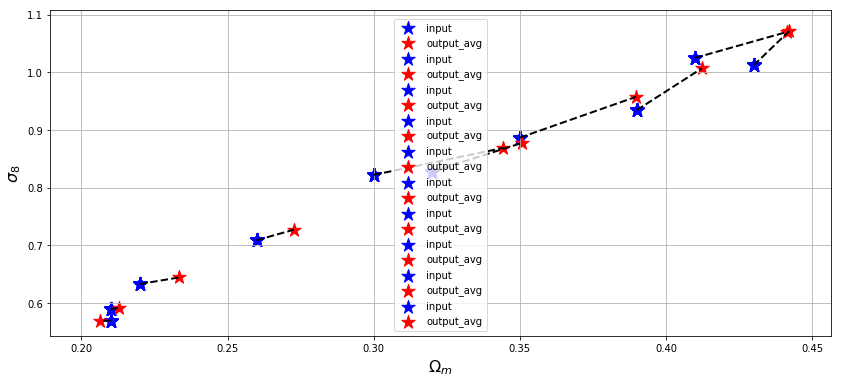

#########################################
Do a fit for  50 epochs:
#########################################
Epoch 1/50
19/19 [==============================] - 217s 11s/step - loss: 1.7523 - mean_squared_error: 1.7523 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 2/50
19/19 [==============================] - 210s 11s/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 3/50
19/19 [==============================] - 210s 11s/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 4/50
19/19 [==============================] - 209s 11s/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 5/50
19/19 [==============================] - 210s 11s/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 6/50
19/19 [==============================] - 209s 11s/step - loss: 0.0151 

19/19 [==============================] - 212s 11s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0015 - val_mean_squared_error: 0.0015


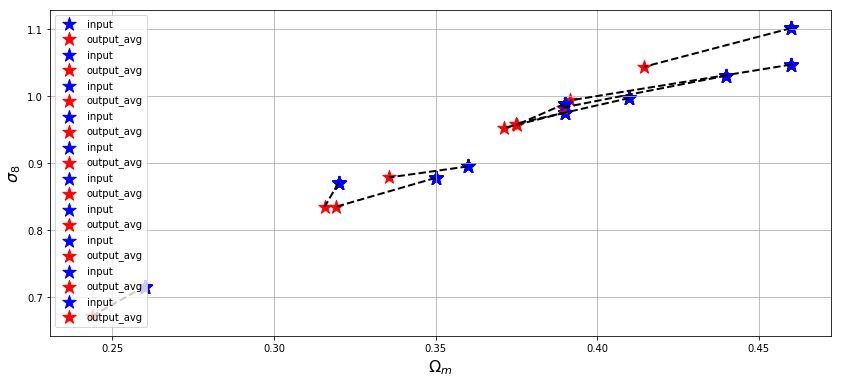

#########################################
Do a fit for  100 epochs:
#########################################
Epoch 1/100
19/19 [==============================] - 221s 12s/step - loss: 1.8337 - mean_squared_error: 1.8337 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 2/100
19/19 [==============================] - 210s 11s/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 3/100
19/19 [==============================] - 213s 11s/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/100
19/19 [==============================] - 212s 11s/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 5/100
19/19 [==============================] - 211s 11s/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/100
19/19 [==============================] - 212s 11s/step - loss: 

Epoch 50/100
19/19 [==============================] - 213s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 7.7615e-04 - val_mean_squared_error: 7.7615e-04
Epoch 51/100
19/19 [==============================] - 215s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 52/100
19/19 [==============================] - 212s 11s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 5.4533e-04 - val_mean_squared_error: 5.4533e-04
Epoch 53/100
19/19 [==============================] - 212s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 54/100
19/19 [==============================] - 214s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 5.6562e-04 - val_mean_squared_error: 5.6562e-04
Epoch 55/100
19/19 [==============================] - 214s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0015 - val_mean_squared_error:

19/19 [==============================] - 212s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 100/100
19/19 [==============================] - 213s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023


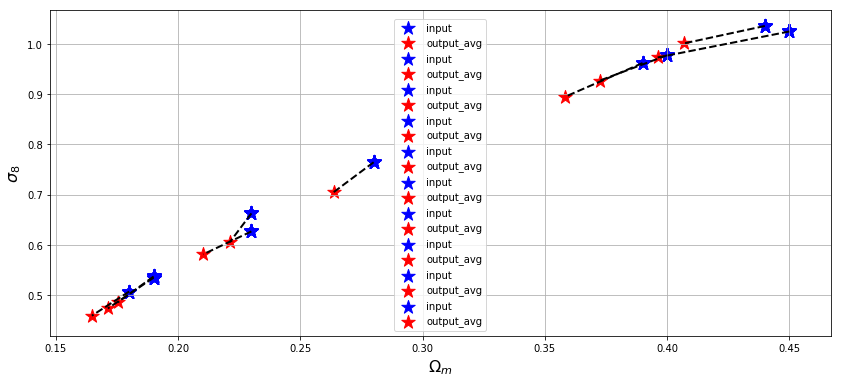

#########################################
Do a fit for  150 epochs:
#########################################
Epoch 1/150
19/19 [==============================] - 224s 12s/step - loss: 1.4616 - mean_squared_error: 1.4616 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/150
19/19 [==============================] - 213s 11s/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/150
19/19 [==============================] - 211s 11s/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/150
19/19 [==============================] - 210s 11s/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/150
19/19 [==============================] - 213s 11s/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 6.1493e-04 - val_mean_squared_error: 6.1493e-04
Epoch 6/150
19/19 [==============================] - 213s 11s/step 

19/19 [==============================] - 213s 11s/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 4.9464e-04 - val_mean_squared_error: 4.9464e-04
Epoch 50/150
19/19 [==============================] - 212s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 6.0594e-04 - val_mean_squared_error: 6.0594e-04
Epoch 51/150
19/19 [==============================] - 213s 11s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 7.2180e-04 - val_mean_squared_error: 7.2180e-04
Epoch 52/150
19/19 [==============================] - 212s 11s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 6.7195e-04 - val_mean_squared_error: 6.7195e-04
Epoch 53/150
19/19 [==============================] - 211s 11s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 4.7519e-04 - val_mean_squared_error: 4.7519e-04
Epoch 54/150
19/19 [==============================] - 212s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 6.9424e-04 - val_mean_squared

19/19 [==============================] - 212s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 99/150
19/19 [==============================] - 211s 11s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 100/150
19/19 [==============================] - 215s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 101/150
19/19 [==============================] - 213s 11s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 102/150
19/19 [==============================] - 211s 11s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 103/150
19/19 [==============================] - 212s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 104/150
19/19 [====

19/19 [==============================] - 211s 11s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 148/150
19/19 [==============================] - 211s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 149/150
19/19 [==============================] - 210s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 150/150
19/19 [==============================] - 210s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 9.9367e-04 - val_mean_squared_error: 9.9367e-04


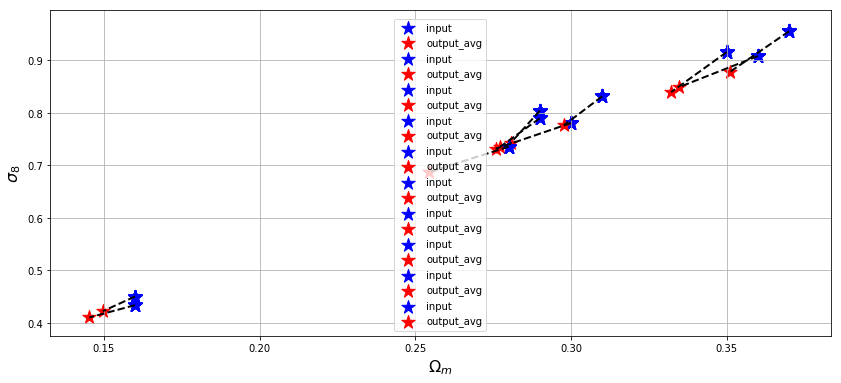

#########################################
Do a fit for  200 epochs:
#########################################
Epoch 1/200
19/19 [==============================] - 219s 12s/step - loss: 1.8024 - mean_squared_error: 1.8024 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 2/200
19/19 [==============================] - 211s 11s/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 3/200
19/19 [==============================] - 211s 11s/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 4/200
19/19 [==============================] - 211s 11s/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 5/200
19/19 [==============================] - 210s 11s/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 6/200
19/19 [==============================] - 210s 11s/step - loss: 

19/19 [==============================] - 215s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 3.9486e-04 - val_mean_squared_error: 3.9486e-04
Epoch 50/200
19/19 [==============================] - 212s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 5.0031e-04 - val_mean_squared_error: 5.0031e-04
Epoch 51/200
19/19 [==============================] - 214s 11s/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 52/200
19/19 [==============================] - 214s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 5.1035e-04 - val_mean_squared_error: 5.1035e-04
Epoch 53/200
19/19 [==============================] - 214s 11s/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 4.9501e-04 - val_mean_squared_error: 4.9501e-04
Epoch 54/200
19/19 [==============================] - 213s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 8.0512e-04 - val_mean_squared_error: 

19/19 [==============================] - 212s 11s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 99/200
19/19 [==============================] - 210s 11s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 100/200
19/19 [==============================] - 212s 11s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 101/200
19/19 [==============================] - 210s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 102/200
19/19 [==============================] - 212s 11s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 103/200
19/19 [==============================] - 213s 11s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 104/200
19/19 [====

Epoch 148/200
19/19 [==============================] - 213s 11s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 149/200
19/19 [==============================] - 213s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 150/200
19/19 [==============================] - 212s 11s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 151/200
19/19 [==============================] - 211s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 152/200
19/19 [==============================] - 210s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 153/200
19/19 [==============================] - 212s 11s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 154/

19/19 [==============================] - 210s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 198/200
19/19 [==============================] - 212s 11s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 199/200
19/19 [==============================] - 211s 11s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 200/200
19/19 [==============================] - 211s 11s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0034 - val_mean_squared_error: 0.0034


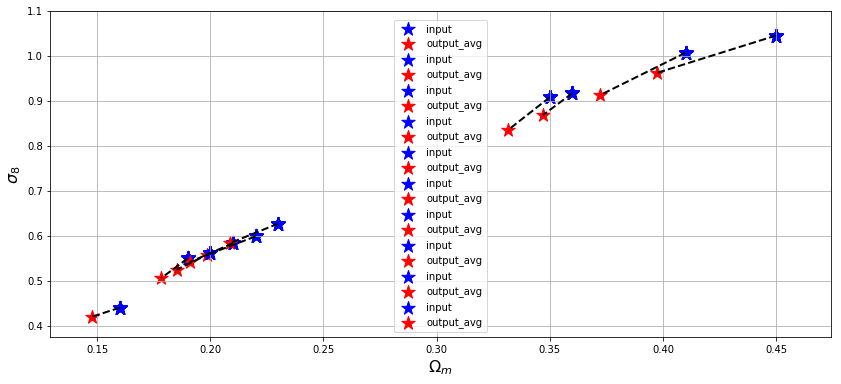

#########################################
Do a fit for  250 epochs:
#########################################
Epoch 1/250
19/19 [==============================] - 220s 12s/step - loss: 0.9617 - mean_squared_error: 0.9617 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/250
19/19 [==============================] - 212s 11s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/250
19/19 [==============================] - 209s 11s/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 4/250
19/19 [==============================] - 208s 11s/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/250
19/19 [==============================] - 210s 11s/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 6/250
19/19 [==============================] - 210s 11s/step - loss: 

19/19 [==============================] - 212s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 50/250
19/19 [==============================] - 214s 11s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 9.5704e-04 - val_mean_squared_error: 9.5704e-04
Epoch 51/250
19/19 [==============================] - 213s 11s/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 9.7757e-04 - val_mean_squared_error: 9.7757e-04
Epoch 52/250
19/19 [==============================] - 211s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 53/250
19/19 [==============================] - 213s 11s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 54/250
19/19 [==============================] - 213s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 55/250


Epoch 99/250
19/19 [==============================] - 213s 11s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 100/250
19/19 [==============================] - 212s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 101/250
19/19 [==============================] - 211s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 102/250
19/19 [==============================] - 214s 11s/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 103/250
19/19 [==============================] - 212s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 104/250
19/19 [==============================] - 213s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 105/2

19/19 [==============================] - 213s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 149/250
19/19 [==============================] - 214s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 150/250
19/19 [==============================] - 213s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 151/250
19/19 [==============================] - 214s 11s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 152/250
19/19 [==============================] - 215s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 153/250
19/19 [==============================] - 213s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 154/250
19/19 [===

19/19 [==============================] - 213s 11s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.9364e-04 - val_mean_squared_error: 7.9364e-04
Epoch 198/250
19/19 [==============================] - 214s 11s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 199/250
19/19 [==============================] - 211s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 200/250
19/19 [==============================] - 214s 11s/step - loss: 9.1152e-04 - mean_squared_error: 9.1152e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 201/250
19/19 [==============================] - 212s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 202/250
19/19 [==============================] - 213s 11s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 20

19/19 [==============================] - 216s 11s/step - loss: 9.2146e-04 - mean_squared_error: 9.2146e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 246/250
19/19 [==============================] - 214s 11s/step - loss: 7.7012e-04 - mean_squared_error: 7.7012e-04 - val_loss: 8.0206e-04 - val_mean_squared_error: 8.0206e-04
Epoch 247/250
19/19 [==============================] - 215s 11s/step - loss: 8.4141e-04 - mean_squared_error: 8.4141e-04 - val_loss: 7.5259e-04 - val_mean_squared_error: 7.5259e-04
Epoch 248/250
19/19 [==============================] - 216s 11s/step - loss: 8.5013e-04 - mean_squared_error: 8.5013e-04 - val_loss: 7.4031e-04 - val_mean_squared_error: 7.4031e-04
Epoch 249/250
19/19 [==============================] - 213s 11s/step - loss: 7.6448e-04 - mean_squared_error: 7.6448e-04 - val_loss: 8.2904e-04 - val_mean_squared_error: 8.2904e-04
Epoch 250/250
19/19 [==============================] - 216s 11s/step - loss: 8.1471e-04 - mean_squared_error: 8.1471e

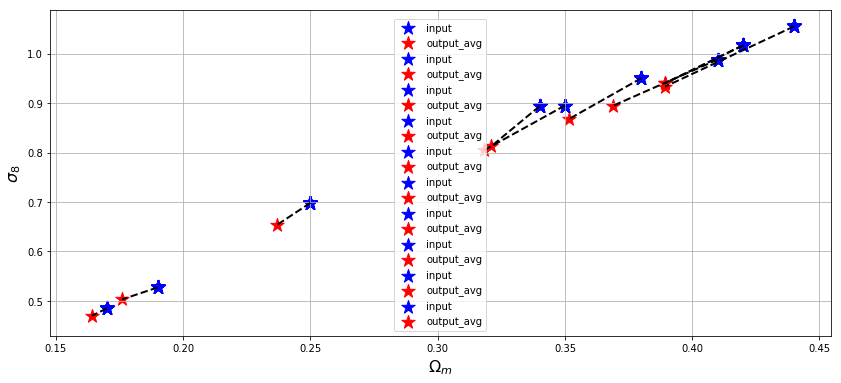

#########################################
Do a fit for  300 epochs:
#########################################
Epoch 1/300
19/19 [==============================] - 225s 12s/step - loss: 2.3517 - mean_squared_error: 2.3517 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 2/300
19/19 [==============================] - 214s 11s/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 3/300
19/19 [==============================] - 214s 11s/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 4/300
19/19 [==============================] - 215s 11s/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 5/300
19/19 [==============================] - 214s 11s/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 6/300
19/19 [==============================] - 215s 11s/step - loss: 

19/19 [==============================] - 229s 12s/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 51/300
19/19 [==============================] - 229s 12s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 52/300
19/19 [==============================] - 215s 11s/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 53/300
19/19 [==============================] - 217s 11s/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 54/300
19/19 [==============================] - 215s 11s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 55/300
19/19 [==============================] - 215s 11s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 56/300
19/19 [=========

Epoch 100/300
19/19 [==============================] - 215s 11s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 101/300
19/19 [==============================] - 215s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 102/300
19/19 [==============================] - 215s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 103/300
19/19 [==============================] - 214s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 104/300
19/19 [==============================] - 215s 11s/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 105/300
19/19 [==============================] - 214s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 106/

19/19 [==============================] - 213s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 150/300
19/19 [==============================] - 215s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 151/300
19/19 [==============================] - 214s 11s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 9.3845e-04 - val_mean_squared_error: 9.3845e-04
Epoch 152/300
19/19 [==============================] - 216s 11s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 153/300
19/19 [==============================] - 215s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 154/300
19/19 [==============================] - 215s 11s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 155/300
19

19/19 [==============================] - 213s 11s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 199/300
19/19 [==============================] - 212s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 200/300
19/19 [==============================] - 213s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 201/300
19/19 [==============================] - 213s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 202/300
19/19 [==============================] - 214s 11s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.9867e-04 - val_mean_squared_error: 9.9867e-04
Epoch 203/300
19/19 [==============================] - 214s 11s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 204/300
19

19/19 [==============================] - 214s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.1028e-04 - val_mean_squared_error: 9.1028e-04
Epoch 247/300
19/19 [==============================] - 213s 11s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 248/300
19/19 [==============================] - 213s 11s/step - loss: 8.5650e-04 - mean_squared_error: 8.5650e-04 - val_loss: 5.8721e-04 - val_mean_squared_error: 5.8721e-04
Epoch 249/300
19/19 [==============================] - 215s 11s/step - loss: 9.5424e-04 - mean_squared_error: 9.5424e-04 - val_loss: 6.5080e-04 - val_mean_squared_error: 6.5080e-04
Epoch 250/300
19/19 [==============================] - 212s 11s/step - loss: 9.4700e-04 - mean_squared_error: 9.4700e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 251/300
19/19 [==============================] - 214s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0015 - val_mea

19/19 [==============================] - 212s 11s/step - loss: 7.8005e-04 - mean_squared_error: 7.8005e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 294/300
19/19 [==============================] - 214s 11s/step - loss: 6.7119e-04 - mean_squared_error: 6.7119e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 295/300
19/19 [==============================] - 214s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 296/300
19/19 [==============================] - 214s 11s/step - loss: 8.0142e-04 - mean_squared_error: 8.0142e-04 - val_loss: 6.6840e-04 - val_mean_squared_error: 6.6840e-04
Epoch 297/300
19/19 [==============================] - 213s 11s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 298/300
19/19 [==============================] - 214s 11s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0017 - val_mean_squared_error:

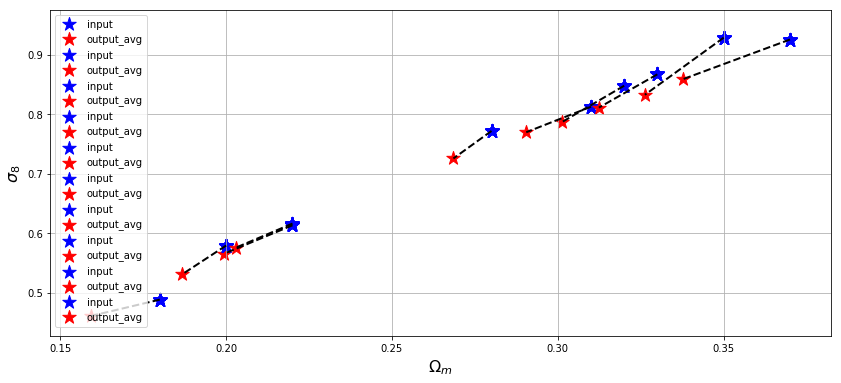

#########################################
Do a fit for  500 epochs:
#########################################
Epoch 1/500
19/19 [==============================] - 222s 12s/step - loss: 1.5123 - mean_squared_error: 1.5123 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 2/500
19/19 [==============================] - 214s 11s/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 3/500
19/19 [==============================] - 214s 11s/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/500
19/19 [==============================] - 215s 11s/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 5/500
19/19 [==============================] - 214s 11s/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/500
19/19 [==============================] - 214s 11s/step - loss: 

19/19 [==============================] - 210s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 7.4413e-04 - val_mean_squared_error: 7.4413e-04
Epoch 50/500
19/19 [==============================] - 213s 11s/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 9.1991e-04 - val_mean_squared_error: 9.1991e-04
Epoch 51/500
19/19 [==============================] - 212s 11s/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 52/500
19/19 [==============================] - 213s 11s/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 53/500
19/19 [==============================] - 213s 11s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 54/500
19/19 [==============================] - 213s 11s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 55/500


Epoch 99/500
19/19 [==============================] - 219s 12s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 100/500
19/19 [==============================] - 217s 11s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 101/500
19/19 [==============================] - 218s 11s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 102/500
19/19 [==============================] - 216s 11s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 103/500
19/19 [==============================] - 218s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 104/500
19/19 [==============================] - 218s 11s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 105/5

19/19 [==============================] - 212s 11s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 149/500
19/19 [==============================] - 214s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 150/500
19/19 [==============================] - 214s 11s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 151/500
19/19 [==============================] - 224s 12s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 152/500
19/19 [==============================] - 218s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 153/500
19/19 [==============================] - 214s 11s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 154/500
 8/19 [===

KeyboardInterrupt: 

In [69]:
models = []

imodel = 0

for epochs in [5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, 500]:

    models.append(keras.Sequential([
        layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),
        layers.Conv3D(128, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, ),
    ]))
    models[imodel].compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])


    print('#########################################')
    print('Do a fit for ', epochs, 'epochs:')
    print('#########################################')
    # *************************************************************************************************
    models[imodel].fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test,y_test))
    # Plot validation
    fig, ax = None, None
    for row in range(10):
        x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
        fig, ax = plot_test(models[imodel], x_test, y_test, fig=fig, ax=ax)
    ax.grid(); plt.show()
    ax.set_title('#-epochs = '+str(100), fontsize=16)
    imodel += 1

In [73]:
row = 0
model_dict = {}
for epochs in [5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, ]:
    model_dict[epochs] = models[row]; row+=1

##### save the models to files

In [94]:
!mkdir ./model1
nowf = open('./model1/info.txt', 'w')
nowf.write('This is the first cnn model we use. See "lsslearn_1(fit_generator_optimization_xiaodongtest).ipynb" for details.')
nowf.close()

# Don't run this!! [may overwrite the files...]
if False:
    for key in model_dict.keys():
        model = model_dict[key]
        filepath = './model1/'+str(key)+'.save'
        keras.models.save_model(model, filepath)

##### load the models

In [96]:
loaded_model = {}
for key in [5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, ]:
    loaded_model[key] = keras.models.load_model('./model1/'+str(key)+'.save')

##### the input-output test

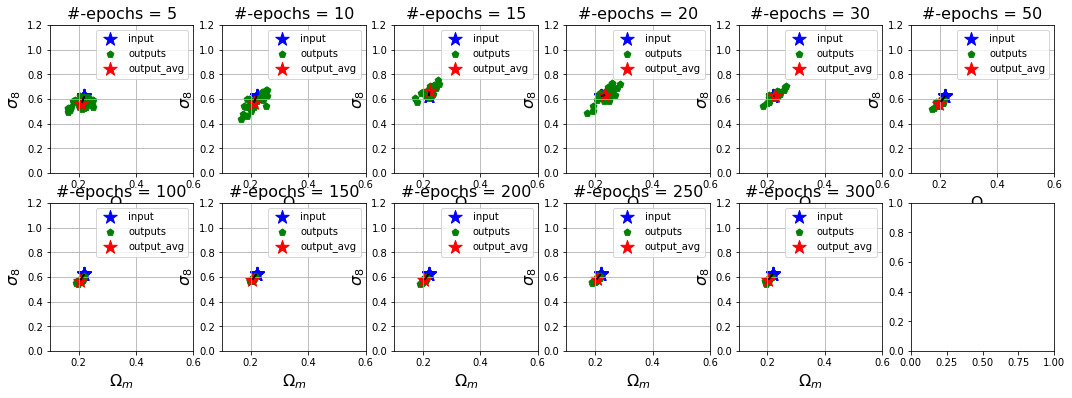

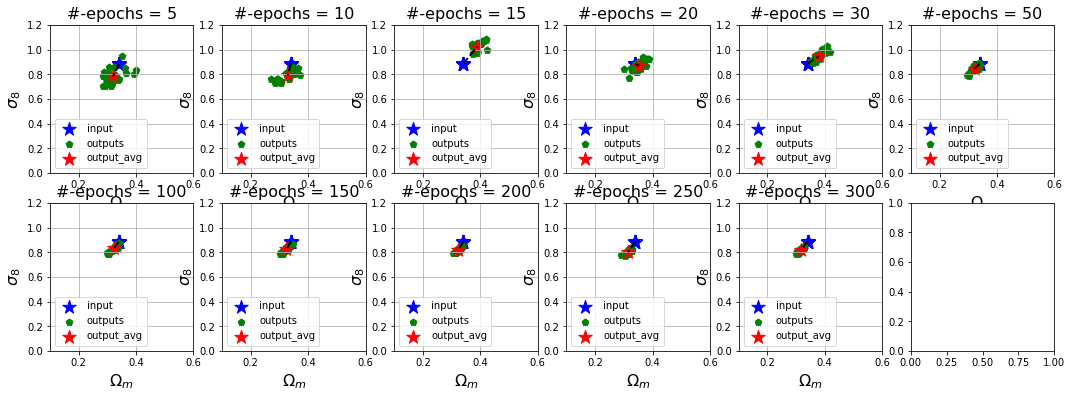

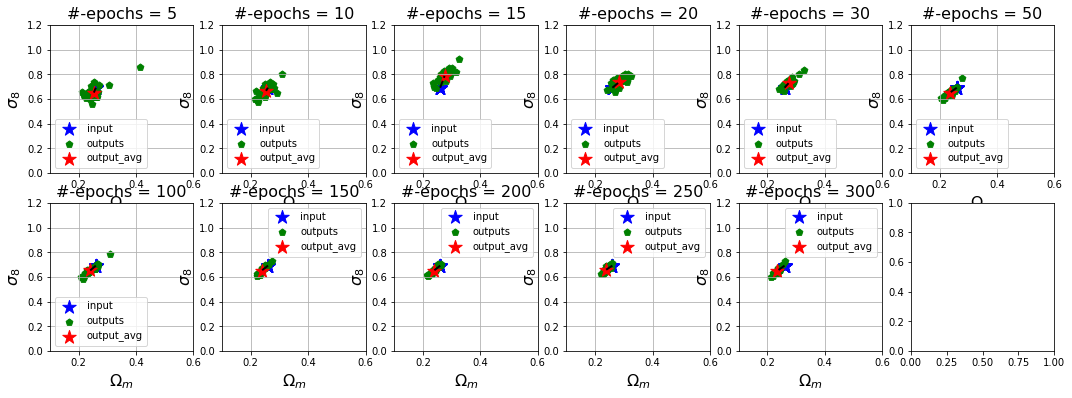

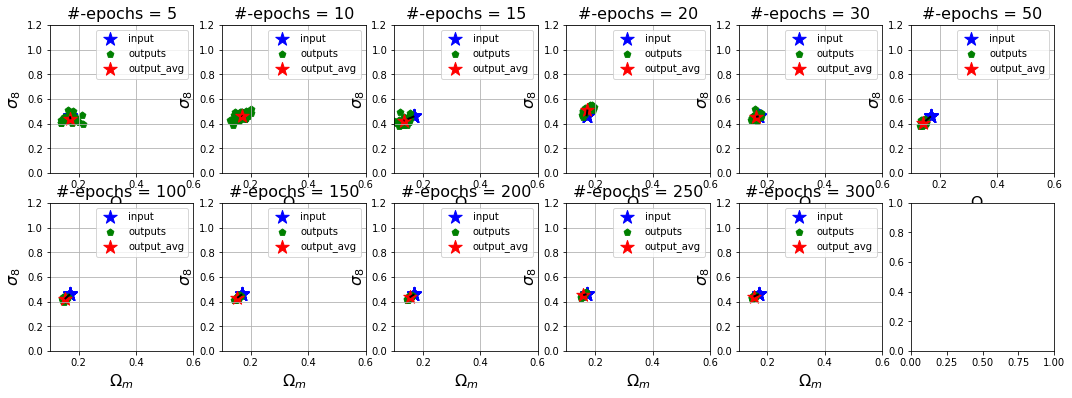

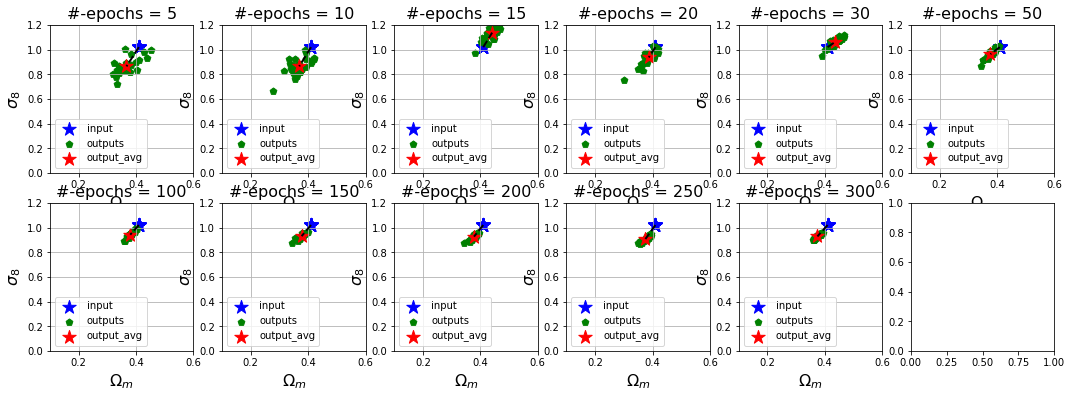

In [97]:
for rand in range(5):
    fig, axs = plt.subplots(nrows=2, ncols = 6, figsize=(18,6))
    axs = axs.reshape(-1)
    for row in range(1):
        x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
        iax = 0; 
        for key in model_dict.keys():
            #model = model_dict[key]    
            model = loaded_model[key]
            fig, ax = fig, axs[iax]
            #print(fig, ax)
            fig, ax = plot_test(model, x_test, y_test, fig=fig, ax=ax, plot_subpoints=True)
            ax.set_xlim(0.1, 0.6); ax.set_ylim(0., 1.2); ax.grid()
            ax.set_title('#-epochs = '+str(key),fontsize=16)
            iax += 1
    #for ax in axs:
    #    ax.set_xlim(0.1, 0.4); ax.set_ylim(0.3, 0.5)
    #    ax.set_title('#-epochs = '+str(key),fontsize=16)
    #    ax.grid(); 
    plt.show()   

##### model2, 10 epochs: Don't run it! (参数已改不可恢复）

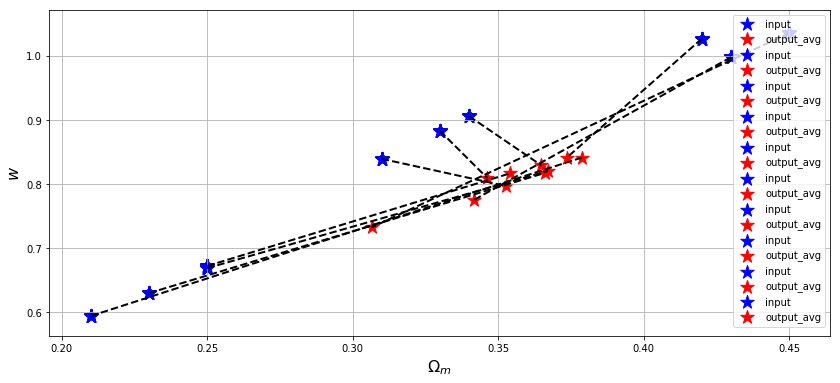

In [177]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model2, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()

##### 50 epochs

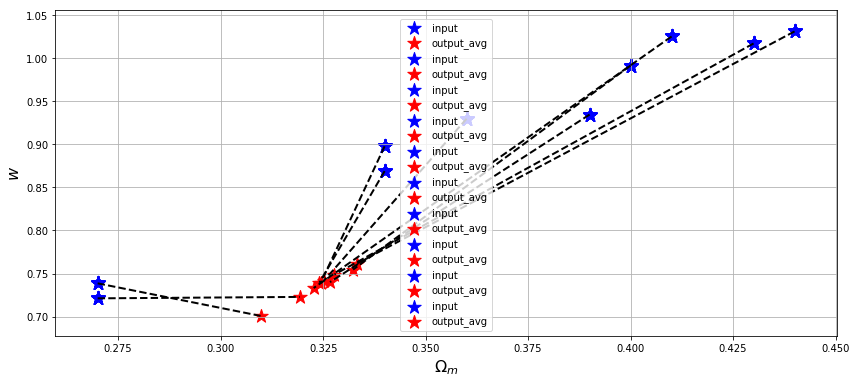

In [182]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model2, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()

##### 300 epochs

In [ ]:
fig, ax = None, None
for row in range(10):
    x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
    fig, ax = plot_test(model2, x_test, y_test, fig=fig, ax=ax)
ax.grid(); plt.show()